In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, Date

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table, view columns
inspector = inspect(engine)
inspector.get_table_names()

meas_col = inspector.get_columns('measurement')
for c in meas_col:
    print(c['name'], c['type'])
print('------------------')
stat_col = inspector.get_columns('station')
for s in stat_col:
    print(s['name'], s['type'])

station = Base.classes.station
measurement = Base.classes.measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement).order_by(measurement.date.desc()).first()
print(f"The most recent date is {most_recent_date.date}")

The most recent date is 2017-08-23


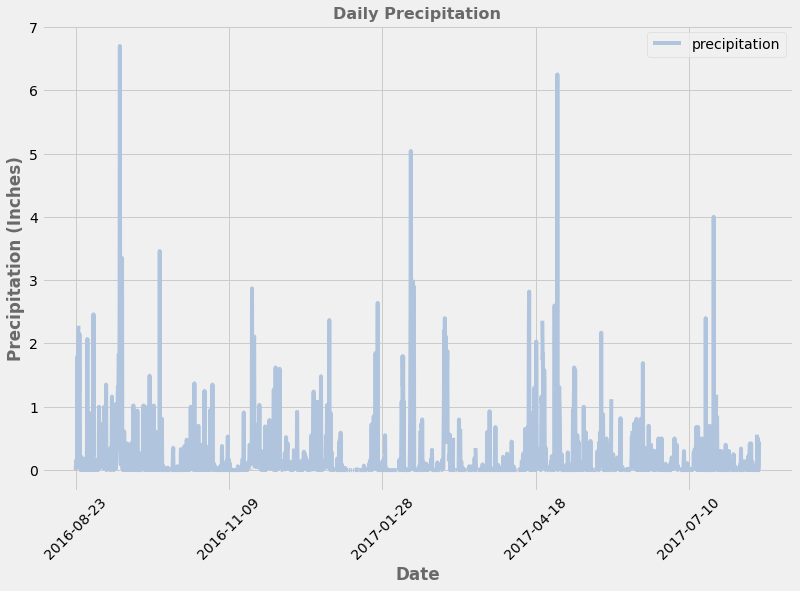

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

date = dt.date(2017, 8, 23) - relativedelta(years=1)
date

# Perform a query to retrieve the data and precipitation scores
last_12_mos = session.query(measurement.date, measurement.prcp).order_by(measurement.date). \
    filter(measurement.date >= date).all()

last_12_mos

precip = pd.DataFrame(last_12_mos, columns=['date', 'precipitation'])

# Save the query results as a Pandas DataFrame and set the index to the date column
precip.set_index('date', inplace=True)
precip.dropna()

# Sort the dataframe by date
precip.sort_index(inplace=True, ascending=True)
precip.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
precip.plot(kind='line', grid=True, figsize=(12,8), color='lightsteelblue', rot=45)
plt.title("Daily Precipitation", fontsize=16, fontweight='bold', color='dimgrey')
plt.xlabel("Date", color='dimgrey', fontweight='bold')
plt.ylabel("Precipitation (Inches)", color='dimgrey', fontweight='bold')
plt.savefig("../sqlalchemy_challenge/Images/12_mos_precip.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.station).group_by(station.station).count()
print(f"There are {station_count} reporting stations.")

There are 9 reporting stations.


In [61]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)). \
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active


most_most_active = most_active[0][0]
most_most_active

'USC00519281'

In [62]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats = session.query(measurement.station, func.avg(measurement.tobs), func.min(measurement.tobs),\
     func.max(measurement.tobs)).filter(measurement.station == most_most_active).all()

stats

[('USC00519281', 71.66378066378067, 54.0, 85.0)]

In [76]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

meas_c = inspector.get_columns('measurement')
for x in meas_c:
    print(x['name'],x['type'])

sta_519281 = session.query(measurement).filter(measurement.station == most_most_active).filter(measurement.date >= date).statement
sta_519281_df = pd.read_sql_query(sta_519281, session.bind)
sta_519281_df.head()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,id,station,date,prcp,tobs
0,14608,USC00519281,2016-08-23,1.79,77.0
1,14609,USC00519281,2016-08-24,2.15,77.0
2,14610,USC00519281,2016-08-25,0.06,80.0
3,14611,USC00519281,2016-08-26,0.01,80.0
4,14612,USC00519281,2016-08-27,0.12,75.0


Text(0.5, 1.0, 'Temeperature Range For Past 12 Months')

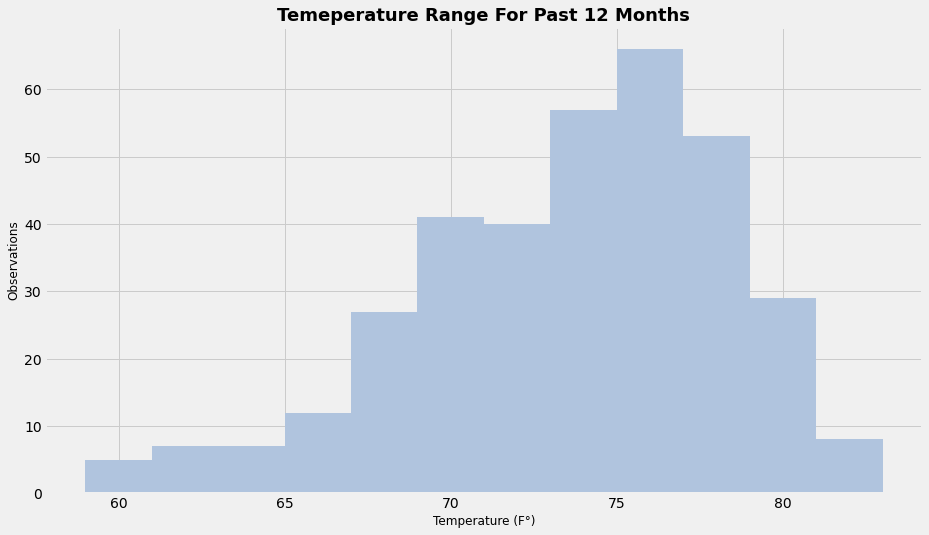

In [93]:
sta_519281_hist = sta_519281_df['tobs']
sta_519281_hist.hist(bins=12, grid=True, figsize=(14,8), color='lightsteelblue')
plt.xlabel("Temperature (F°)", fontsize=12)
plt.ylabel("Observations", fontsize=12)
plt.title("Temeperature Range For Past 12 Months", fontsize=18, fontweight='bold')

# Close session

In [94]:
# Close Session
session.close()